In [1]:
import os
import re
import pickle
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import torch
import tifffile
from einops import rearrange, repeat

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
# import mushroom.data.datasets as datasets
# import mushroom.data.visium as visium
# import mushroom.data.xenium as xenium
# from mushroom.mushroom import Mushroom

In [5]:
project_dir = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/'

In [17]:
case_order = [
#     'HT339B2-H1',
#     'HT565B1-H2',
#     'HT268B1',
#     'HT397B1',
#     'HT206B1',
#     'C3L-01287',
#     'C3L-00982',
#     'C3L-02551',
#     'HT413C1-K2',
#     'HT225C1',
#     'HT448C1-Th1K1Fp1',
#     'HT413C1-Th1k4A1',
#     'HT553P1-H2',
    'S18-9906', # done seperately
    'S18-5591-C8'
]

disease_to_cases = {
    'breast': ['HT206B1', 'HT268B1', 'HT339B2-H1', 'HT397B1', 'HT565B1-H2'],
    'crc': ['HT225C1', 'HT413C1-K2', 'HT413C1-Th1k4A1', 'HT448C1-Th1K1Fp1'],
    'ccrcc': ['C3L-01287', 'C3L-00982', 'C3L-02551'],
    'pdac': ['HT553P1-H2'],
    'prostate': ['S18-9906', 'S18-5591-C8']
}
case_to_disease = {v:k for k, vs in disease_to_cases.items() for v in vs}

disease_to_meta = {
    'breast': '/diskmnt/Datasets/Spatial_Transcriptomics/Analysis/ST_subclone/28-snRNA/28_0-snRNA_obj_merged/Breast/metadata_table_Breast.tsv',
    'crc': '/diskmnt/Datasets/Spatial_Transcriptomics/Analysis/ST_subclone/28-snRNA/28_0-snRNA_obj_merged/Colon/metadata_table_Colon.tsv',
    'ccrcc': '/diskmnt/Datasets/Spatial_Transcriptomics/Analysis/ST_subclone/28-snRNA/28_0-snRNA_obj_merged/Kidney/metadata_table_Kidney.tsv',
    'pdac': '/diskmnt/Datasets/Spatial_Transcriptomics/Analysis/ST_subclone/28-snRNA/28_0-snRNA_obj_merged/Pancreas/metadata_table_Pancreas.tsv',
    'prostate': '/diskmnt/Datasets/mmy_scratch/Prostate/fullobject_metadataupdate.txt',
}


In [18]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/true_pixels_raw.pkl$'))
fps

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/true_pixels_raw.pkl',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/true_pixels_raw.pkl',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/true_pixels_raw.pkl',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/true_pixels_raw.pkl',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/true_pixels_raw.pkl',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/true_pixels_raw.pkl',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/true_pixels_raw.pkl',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/true_pixels_raw.pkl',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submis

In [24]:
# from collections import Counter
# n = 5000
# for disease in list(disease_to_cases.keys()):
#     print(disease)
#     adata = sc.read_h5ad(os.path.join(project_dir, 'single_cell', f'{disease}.h5ad'))
#     adata.X = adata.raw.X
    
#     meta = pd.read_csv(disease_to_meta[disease], sep='\t')
#     if disease in ['prostate']:
#         meta['cell_type'] = meta['celltype_broad']
#         exclude = ['unlabeled', 'Myeloid_Aspirate_Specific', 'EPCAM+_Liver', 'Hepatocytes']
#         meta = meta[[True if x not in exclude else False for x in meta['cell_type']]]
#     elif disease in ['crc']:
#         meta = meta[meta['any_outlier']!='Outlier']
#         meta['cell_type'] = meta['cell_type_final']
#     else:
#         meta = meta[meta['any_outlier']!='Outlier']
#         meta['cell_type'] = meta['cell_type_20240314']
    
#     print(adata.shape)
    
    

#     adata.obs['cell_type'] = meta.loc[[x for x in adata.obs.index.to_list() if x in meta.index]]['cell_type']
#     adata = adata[~pd.isnull(adata.obs['cell_type'])]
    
#     # downsample
#     cell_types = sorted(set(adata.obs['cell_type']))
#     cell_ids = []
#     for ct in cell_types:
#         f = adata.obs[adata.obs['cell_type']==ct]
#         if f.shape[0] > n:
#             cell_ids += np.random.choice(f.index.to_list(), size=n, replace=False).tolist()
#         else:
#             cell_ids += f.index.to_list()
# #     print(cell_ids)
#     adata = adata[cell_ids]
#     print(adata.shape)
#     print(Counter(adata.obs['cell_type']))

#     exp_df = pd.DataFrame(data=adata.X.toarray().astype(int),
#                           columns=adata.var.index.to_list(),
#                           index=adata.obs.index.to_list()).T
#     exp_df.index.name = 'GENES'
    
#     sc_annot = adata.obs[['cell_type']]
#     sc_annot.index.name = 'Cell IDs'
#     sc_annot.columns = ['CellType']
    
#     out_dir = os.path.join(project_dir, 'cytospace', disease)
#     Path(out_dir).mkdir(parents=True, exist_ok=True)
#     exp_df.to_csv(os.path.join(out_dir, 'input_sc_exp.txt'), sep='\t')
#     sc_annot.to_csv(os.path.join(out_dir, 'input_sc_annot.txt'), sep='\t')

In [25]:
# for case in case_order:
#     fp = os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels_raw.pkl')
#     dtype_to_true_pixels = pickle.load(open(fp, 'rb'))

#     dtypes = [k for k in dtype_to_true_pixels.keys() if k in ['visium', 'xenium']]
#     for dtype in dtypes:
#         channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
#         for section_idx, tp in enumerate(true_pixels):
#             print(case, dtype, section_idx)

#             if dtype in ['visium']:
#                 tp *= 10

#             grids = np.meshgrid(np.arange(tp.shape[0]), np.arange(tp.shape[1]), indexing='ij')
#             ids = [f'h{i}_w{j}' for i, j in rearrange(grids, 'z ... -> (...) z')]
#             spatial_counts = pd.DataFrame(data=rearrange(tp, '... c -> (...) c').astype(int),
#                                           columns=channels, index=ids)
#             cs = [c for c, v in zip(spatial_counts.columns, (spatial_counts.sum(0)>0).to_list()) if v]
#             spatial_counts = spatial_counts[spatial_counts.sum(1)>=10][cs]
#             spatial_counts = spatial_counts.T
#             spatial_counts.index.name = 'V1'
 
#             data = []
#             for x in spatial_counts.columns:
#                 row = re.sub(r'^.*h([0-9]+).*$', r'\1', x)
#                 col = re.sub(r'^.*w([0-9]+).*$', r'\1', x)
#                 data.append([row, col])
#             coord_df = pd.DataFrame(data=data, columns=['row', 'col'], index=spatial_counts.columns)
#             coord_df.index.name = 'SpotID'


#             out_dir = os.path.join(project_dir, case, f'cytospace_{dtype}_section{section_idx}')
#             Path(out_dir).mkdir(parents=True, exist_ok=True)
#             spatial_counts.to_csv(os.path.join(out_dir, f'input_counts.txt'), sep='\t')
#             coord_df.to_csv(os.path.join(out_dir, f'input_coords.txt'), sep='\t')

In [20]:
sc_exp_fps = sorted(utils.listfiles(os.path.join(project_dir, 'cytospace'), regex=r'input_sc_exp.txt$'))
sc_annot_fps = sorted(utils.listfiles(os.path.join(project_dir, 'cytospace'), regex=r'input_sc_annot.txt$'))
sp_exp_fps = sorted(utils.listfiles(os.path.join(project_dir), regex=r'cytospace_.*_section[0-9]+.input_counts.txt$'))
sp_coord_fps = sorted(utils.listfiles(os.path.join(project_dir), regex=r'cytospace_.*_section[0-9]+.input_coords.txt$'))


In [21]:
sc_exp_fps, sc_annot_fps

(['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/cytospace/breast/input_sc_exp.txt',
  '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/cytospace/ccrcc/input_sc_exp.txt',
  '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/cytospace/crc/input_sc_exp.txt',
  '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/cytospace/pdac/input_sc_exp.txt',
  '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/cytospace/prostate/input_sc_exp.txt'],
 ['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/cytospace/breast/input_sc_annot.txt',
  '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/cytospace/ccrcc/input_sc_annot.txt',
  '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/cytospace/crc/input_sc_annot.txt',
  '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/cytospace/pdac/input_sc_annot.txt',
  '/diskmnt/Projects/Users/es

In [22]:
sp_exp_fps

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00982/cytospace_xenium_section0/input_counts.txt',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-01287/cytospace_xenium_section0/input_counts.txt',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-02551/cytospace_xenium_section0/input_counts.txt',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section0/input_counts.txt',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section1/input_counts.txt',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section2/input_counts.txt',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section3/input_counts.txt',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section4/input_counts.txt',
 '

In [23]:
for sp_exp_fp, sp_coord_fp in zip(sp_exp_fps, sp_coord_fps):
    case = sp_exp_fp.split('/')[-3]
    disease = case_to_disease[case]
    
    root = sp_exp_fp.replace('/input_counts.txt', '')
    output_dir = os.path.join(root, 'outputs')
    
    sc_exp_fp = [fp for fp in sc_exp_fps if fp.split('/')[-2]==disease][0]
    sc_annot_fp = [fp for fp in sc_annot_fps if fp.split('/')[-2]==disease][0]
    # cytospace -sp input_sc_exp.txt -ctp input_sc_annot.txt -cp input_visium_coords.txt -stp input_visium_counts.txt -o outputs -sm lap_CSPR -mcn 20 -g square -sss -nosss 5000 -nop 5
    cmd = f'cytospace -sp {sc_exp_fp} -ctp {sc_annot_fp} -cp {sp_coord_fp} -stp {sp_exp_fp} -o {output_dir} -sm lap_CSPR -mcn 20 -g square -sss -nosss 5000 -nop 5'
    print(cmd)
    
    
    
    

cytospace -sp /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/cytospace/ccrcc/input_sc_exp.txt -ctp /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/cytospace/ccrcc/input_sc_annot.txt -cp /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00982/cytospace_xenium_section0/input_coords.txt -stp /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00982/cytospace_xenium_section0/input_counts.txt -o /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00982/cytospace_xenium_section0/outputs -sm lap_CSPR -mcn 20 -g square -sss -nosss 5000 -nop 5
cytospace -sp /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/cytospace/ccrcc/input_sc_exp.txt -ctp /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/cytospace/ccrcc/input_sc_annot.txt -cp /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-01287/cytospace_xenium_section0/input_coords.txt 

In [32]:
fps = sorted(utils.listfiles(project_dir, regex=r'cytospace_.*/outputs/cell_type_assignments_by_spot.csv$'))
fps

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00982/cytospace_xenium_section0/outputs/cell_type_assignments_by_spot.csv',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-01287/cytospace_xenium_section0/outputs/cell_type_assignments_by_spot.csv',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-02551/cytospace_xenium_section0/outputs/cell_type_assignments_by_spot.csv',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section0/outputs/cell_type_assignments_by_spot.csv',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section1/outputs/cell_type_assignments_by_spot.csv',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section2/outputs/cell_type_assignments_by_spot.csv',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_sect

In [33]:
for fp in fps:
    pieces = fp.split('/')
    case = pieces[-4]
    src_dir = '/'.join(pieces[:-2])
    target_dir = os.path.join('/data/estorrs/mushroom/data/projects/submission_v1', case)
    cmd = f'scp -r {src_dir} estorrs@glacier.wusm.wustl.edu:{target_dir}'
    print(cmd)

scp -r /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00982/cytospace_xenium_section0 estorrs@glacier.wusm.wustl.edu:/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982
scp -r /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-01287/cytospace_xenium_section0 estorrs@glacier.wusm.wustl.edu:/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287
scp -r /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-02551/cytospace_xenium_section0 estorrs@glacier.wusm.wustl.edu:/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551
scp -r /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section0 estorrs@glacier.wusm.wustl.edu:/data/estorrs/mushroom/data/projects/submission_v1/HT206B1
scp -r /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/cytospace_xenium_section1 estorrs@glacier.wusm.wustl.edu:/data/estorrs/mushroom/data/projects/submission

## testing

In [265]:
import mushroom.data.xenium as xenium

In [266]:
a = xenium.adata_from_xenium(
    '/diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010784__S18-9906-B27Us1_2Q1__20230912__220421'
)
a

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


AnnData object with n_obs × n_vars = 270707 × 377
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'ppm'
    obsm: 'spatial'

In [312]:
case = 'S18-9906'
# case = 'S18-5591-C8'

dtype = 'visium'

In [313]:
dtype_to_true_pixels = pickle.load(
    open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels_raw.pkl'), 'rb')
)
channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
true_pixels = np.stack(true_pixels)
tp = true_pixels[0]

if dtype in ['visium']:
    tp *= 10
#     true_pixels = np.exp(true_pixels) - 1 # undo logp1
tp.shape

(172, 172, 17943)

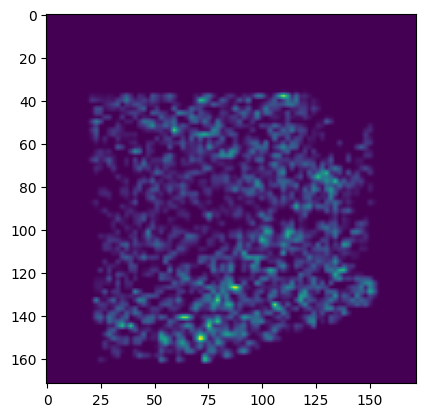

In [314]:
img = tp[..., channels.index('EPCAM')]
plt.imshow(img)

In [315]:
adata.var

,features
MIR1302-2HG,MIR1302-2HG
FAM138A,FAM138A
OR4F5,OR4F5
AL627309.1,AL627309.1
AL627309.3,AL627309.3
...,...
AC141272.1,AC141272.1
AC023491.2,AC023491.2
AC007325.1,AC007325.1
AC007325.4,AC007325.4


In [316]:
adata = sc.read_h5ad(os.path.join(project_dir, 'single_cell', 'prostate.h5ad'))
adata.X = adata.raw.X
adata

AnnData object with n_obs × n_vars = 34173 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'doublet_score_rna', 'predicted_doublet_rna', 'doublet_score_atac', 'predicted_doublet_atac', 'predicted_doublet', 'nCount_ATAC_MACS2', 'nFeature_ATAC_MACS2', 'pct_read_i

In [317]:
common = sorted(set(adata.var.index.to_list()).intersection(set(channels)))
len(common)

17941

In [318]:
a = adata[:, common]
tp = tp[..., [channels.index(x) for x in common]]

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [319]:
np.unique(tp[..., common.index('EPCAM')])

array([0.0000000e+00, 1.0725377e-04, 1.2987418e-04, ..., 5.4616871e+01,
       5.5226345e+01, 5.8487556e+01], dtype=float32)

In [320]:
meta = pd.read_csv('/diskmnt/Datasets/mmy_scratch/Prostate/fullobject_metadataupdate.txt', sep='\t')
meta

,celltype_broad
PB035Z1_S1_AAACATGCAGATTCAT-1,Luminal_Tumor
PB035Z1_S1_AAACATGCATAGTCAT-1,Hillock_Cells
PB035Z1_S1_AAACCAACAGCGCTTG-1,Hillock_Cells
PB035Z1_S1_AAACCAACAGGTTAAA-1,Hillock_Cells
PB035Z1_S1_AAACCAACATATTGAC-1,Luminal_Tumor
...,...
_PB292Z1-Tj1_TTTCGATAGTCTAGCT-1,T_NK
_PB292Z1-Tj1_TTTGACTCAAGAATAC-1,T_NK
_PB292Z1-Tj1_TTTGACTCAAGTATAG-1,Myeloid_Aspirate_Specific
_PB292Z1-Tj1_TTTGATCAGCCATATC-1,T_NK


In [321]:
a.obs['celltype_broad'] = meta.loc[a.obs.index.to_list()]['celltype_broad']
a.obs

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_169949/891971596.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs['celltype_broad'] = meta.loc[a.obs.index.to_list()]['celltype_broad']


,orig.ident,nCount_RNA,nFeature_RNA,is_cell,excluded_reason,gex_raw_reads,gex_mapped_reads,gex_conf_intergenic_reads,gex_conf_exonic_reads,gex_conf_intronic_reads,...,seurat_clusters,celltype_rj,assay,rho,percent.rb,doublet_score,SCT_snn_res.0.5,SCT_snn_res.0.6,customclassif,celltype_broad
PB035Z1_S1_AAACATGCAGATTCAT-1,PB035Z1-S1Fc1Nd1,2137,1322,1,0,9482,8948,608,2085,5953,...,2,,Multiome,NA,NA,NA,2,10,Cancer cells,Luminal_Tumor
PB035Z1_S1_AAACATGCATAGTCAT-1,PB035Z1-S1Fc1Nd1,1530,1131,1,0,6820,6411,467,1547,4194,...,6,,Multiome,NA,NA,NA,6,4,HSC/MPP cells,Hillock_Cells
PB035Z1_S1_AAACCAACAGCGCTTG-1,PB035Z1-S1Fc1Nd1,1300,931,1,0,5772,5492,446,1186,3647,...,6,,Multiome,NA,NA,NA,6,4,HSC/MPP cells,Hillock_Cells
PB035Z1_S1_AAACCAACAGGTTAAA-1,PB035Z1-S1Fc1Nd1,1353,905,1,0,5427,4976,321,1241,3194,...,6,,Multiome,NA,NA,NA,6,4,HSC/MPP cells,Hillock_Cells
PB035Z1_S1_AAACCAACATATTGAC-1,PB035Z1-S1Fc1Nd1,4398,1978,1,0,18499,17507,1053,3376,12413,...,2,,Multiome,NA,NA,NA,2,10,Cancer cells,Luminal_Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_PB292Z1-Tj1_TTTCGATAGTCTAGCT-1,PB292Z1-Tj1N1Zt1_1Bn1_1,1515,916,NA,NA,NA,NA,NA,NA,NA,...,1,T_NK,snRNA,0.016,0.33003300330033,0.0183727034120735,1,1,Memory CD8+ T cells,T_NK
_PB292Z1-Tj1_TTTGACTCAAGAATAC-1,PB292Z1-Tj1N1Zt1_1Bn1_1,1246,879,NA,NA,NA,NA,NA,NA,NA,...,1,T_NK,snRNA,0.016,0.481540930979133,0.00342596117244005,1,1,Memory CD8+ T cells,T_NK
_PB292Z1-Tj1_TTTGACTCAAGTATAG-1,PB292Z1-Tj1N1Zt1_1Bn1_1,4848,2018,NA,NA,NA,NA,NA,NA,NA,...,15,,snRNA,0.016,0.123762376237624,0.0583382439599293,15,15,Granulocytes,Myeloid_Aspirate_Specific
_PB292Z1-Tj1_TTTGATCAGCCATATC-1,PB292Z1-Tj1N1Zt1_1Bn1_1,1570,1036,NA,NA,NA,NA,NA,NA,NA,...,1,T_NK,snRNA,0.016,0.191082802547771,0.0364372469635628,1,1,Memory CD8+ T cells,T_NK


In [322]:
for name in set(a.obs['orig.ident']):
    print(name)
    print(sorted(set(a[a.obs['orig.ident']==name].obs['celltype_broad'])))

PB017Z1-S1Fc1Nd1
['B', 'Basal_Epithelium', 'Club_Cells', 'EPCAM+_Liver', 'Endothelial', 'Hepatocytes', 'Hillock_Cells', 'Luminal_Epithelium', 'Luminal_Tumor', 'Myeloid', 'Myeloid_Aspirate_Specific', 'Smooth_Muscle_Cells_Fibroblast_Mix', 'T_NK', 'unlabeled']
PB035Z1-S1Fc1Nd1
['B', 'Basal_Epithelium', 'Club_Cells', 'EPCAM+_Liver', 'Endothelial', 'Hepatocytes', 'Hillock_Cells', 'Luminal_Epithelium', 'Luminal_Tumor', 'Myeloid', 'Myeloid_Aspirate_Specific', 'Smooth_Muscle_Cells_Fibroblast_Mix', 'T_NK']
PB145Z1-Ty1Fc1Y1N1Zt1_1Bn1_1


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


['B', 'Basal_Epithelium', 'Club_Cells', 'EPCAM+_Liver', 'Endothelial', 'Hepatocytes', 'Hillock_Cells', 'Luminal_Epithelium', 'Luminal_Tumor', 'Myeloid', 'Myeloid_Aspirate_Specific', 'Smooth_Muscle_Cells_Fibroblast_Mix', 'T_NK', 'unlabeled']
PB026Z1-S1Fc1Nd1
['B', 'Basal_Epithelium', 'EPCAM+_Liver', 'Endothelial', 'Hepatocytes', 'Hillock_Cells', 'Luminal_Epithelium', 'Luminal_Tumor', 'Myeloid', 'Myeloid_Aspirate_Specific', 'Smooth_Muscle_Cells_Fibroblast_Mix', 'T_NK', 'unlabeled']
PB108Z1-Th1Fc1Y1N1Zt1_1Bn1_1
['B', 'Club_Cells', 'EPCAM+_Liver', 'Endothelial', 'Hepatocytes', 'Hillock_Cells', 'Luminal_Epithelium', 'Myeloid', 'Myeloid_Aspirate_Specific', 'Smooth_Muscle_Cells_Fibroblast_Mix', 'T_NK']
PB292Z1-Tj1N1Zt1_1Bn1_1
['B', 'Endothelial', 'Hepatocytes', 'Hillock_Cells', 'Luminal_Epithelium', 'Luminal_Tumor', 'Myeloid', 'Myeloid_Aspirate_Specific', 'Smooth_Muscle_Cells_Fibroblast_Mix', 'T_NK']
PB151Z1-Tp1Fc1Y1N1Zt1_1Bn1_1
['B', 'EPCAM+_Liver', 'Hillock_Cells', 'Luminal_Epithelium', 'Lu

In [323]:
# include = [
#     'PB017Z1-S1Fc1Nd1',
#     'PB026Z1-S1Fc1Nd1',
#     'PB035Z1-S1Fc1Nd1'
# ]
# adata = adata[np.asarray([True if x in include else False for x in adata.obs['orig.ident']])]
# adata

In [324]:
from collections import Counter
Counter(a.obs['celltype_broad']).most_common()

[('Luminal_Epithelium', 12208),
 ('Luminal_Tumor', 4440),
 ('T_NK', 3428),
 ('EPCAM+_Liver', 2790),
 ('Basal_Epithelium', 2011),
 ('Hepatocytes', 1995),
 ('Smooth_Muscle_Cells_Fibroblast_Mix', 1730),
 ('Myeloid', 1688),
 ('B', 1485),
 ('Endothelial', 999),
 ('Myeloid_Aspirate_Specific', 682),
 ('Hillock_Cells', 595),
 ('Club_Cells', 69),
 ('unlabeled', 53)]

In [325]:
from collections import Counter
Counter(a.obs['customclassif']).most_common()

[('Unknown', 10484),
 ('Cancer cells', 6638),
 ('Memory CD8+ T cells', 3428),
 ('Natural killer  cells', 2320),
 ('HSC/MPP cells', 2254),
 ('Neutrophils', 1995),
 ('Plasmacytoid Dendritic cells', 1730),
 ('Macrophages', 1688),
 ('Naive B cells', 1485),
 ('Endothelial', 999),
 ('Granulocytes', 682),
 ('Plasma B cells', 470)]

In [326]:
exclude = ['unlabeled', 'Myeloid_Aspirate_Specific', 'EPCAM+_Liver', 'Hepatocytes']
a = a[np.asarray([True if x not in exclude else False for x in adata.obs['celltype_broad']])]
a

View of AnnData object with n_obs × n_vars = 28653 × 17941
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'doublet_score_rna', 'predicted_doublet_rna', 'doublet_score_atac', 'predicted_doublet_atac', 'predicted_doublet', 'nCount_ATAC_MACS2', 'nFeature_ATAC_MACS2', 'pc

In [327]:
np.unique(a.raw.X[0].toarray())

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  17.,  34., 105.])

In [328]:
exp_df = pd.DataFrame(data=a.X.toarray().astype(int), columns=common, index=a.obs.index.to_list()).T
exp_df.index.name = 'GENES'

exp_df

,PB035Z1_S1_AAACATGCAGATTCAT-1,PB035Z1_S1_AAACATGCATAGTCAT-1,PB035Z1_S1_AAACCAACAGCGCTTG-1,PB035Z1_S1_AAACCAACAGGTTAAA-1,PB035Z1_S1_AAACCAACATATTGAC-1,PB035Z1_S1_AAACCGAAGTAAGAAC-1,PB035Z1_S1_AAACCGCGTCGCAAAC-1,PB035Z1_S1_AAACCGGCAATGAGGT-1,PB035Z1_S1_AAACCGGCAATTGACT-1,PB035Z1_S1_AAACCGGCACAAACTT-1,...,_PB292Z1-Tj1_TTTCAGTAGTTAGAAC-1,_PB292Z1-Tj1_TTTCAGTGTTATCTGG-1,_PB292Z1-Tj1_TTTCATGCACCCTAAA-1,_PB292Z1-Tj1_TTTCATGGTCTTCAAG-1,_PB292Z1-Tj1_TTTCATGTCACGAACT-1,_PB292Z1-Tj1_TTTCCTCTCCCGGTAG-1,_PB292Z1-Tj1_TTTCGATAGTCTAGCT-1,_PB292Z1-Tj1_TTTGACTCAAGAATAC-1,_PB292Z1-Tj1_TTTGATCAGCCATATC-1,_PB292Z1-Tj1_TTTGTTGGTAGACAGC-1
GENES,,,,,,,,,,,,,,,,,,,,,
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A3GALT2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0,0,0,1,3,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
ZYG11A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZYG11B,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [329]:
sc_annot = meta.loc[a.obs.index.to_list()]
sc_annot.index.name = 'Cell IDs'
sc_annot.columns = ['CellType']
sc_annot

,CellType
Cell IDs,
PB035Z1_S1_AAACATGCAGATTCAT-1,Luminal_Tumor
PB035Z1_S1_AAACATGCATAGTCAT-1,Hillock_Cells
PB035Z1_S1_AAACCAACAGCGCTTG-1,Hillock_Cells
PB035Z1_S1_AAACCAACAGGTTAAA-1,Hillock_Cells
PB035Z1_S1_AAACCAACATATTGAC-1,Luminal_Tumor
...,...
_PB292Z1-Tj1_TTTCCTCTCCCGGTAG-1,B
_PB292Z1-Tj1_TTTCGATAGTCTAGCT-1,T_NK
_PB292Z1-Tj1_TTTGACTCAAGAATAC-1,T_NK


In [330]:
tp.shape

(172, 172, 17941)

In [331]:
grids = np.meshgrid(
    np.arange(tp.shape[0]), np.arange(tp.shape[1]),
    indexing='ij')
grids = np.stack(grids)
grids.shape

(2, 172, 172)

In [332]:
ids = [f'h{i}-w{j}' for i, j in rearrange(grids, 'z ... -> (...) z')]
ids[:10]

['h0-w0',
 'h0-w1',
 'h0-w2',
 'h0-w3',
 'h0-w4',
 'h0-w5',
 'h0-w6',
 'h0-w7',
 'h0-w8',
 'h0-w9']

In [333]:
spatial_counts.sum(1)>=10

V1
h35_w107    True
h35_w108    True
h35_w109    True
h35_w110    True
h35_w111    True
            ... 
h162_w73    True
h162_w74    True
h162_w75    True
h162_w76    True
h162_w77    True
Length: 15704, dtype: bool

In [334]:
spatial_counts.sum(0)>0

A1BG       True
A2M        True
A3GALT2    True
A4GALT     True
A4GNT      True
           ... 
ZXDC       True
ZYG11A     True
ZYG11B     True
ZYX        True
ZZEF1      True
Length: 16209, dtype: bool

In [335]:
spatial_counts.shape

(15704, 16209)

In [336]:
masked_channels = [c for c, v in zip(spatial_counts.columns, (spatial_counts.sum(0)>0).to_list()) if v]
len(masked_channels)

16209

In [337]:
spatial_counts = pd.DataFrame(data=rearrange(tp, '... c -> (...) c').astype(int),
                              columns=common, index=ids)
cs = [c for c, v in zip(spatial_counts.columns, (spatial_counts.sum(0)>0).to_list()) if v]
spatial_counts = spatial_counts[spatial_counts.sum(1)>=10][cs]
spatial_counts = spatial_counts.T
spatial_counts.index.name = 'V1'
spatial_counts

,h35-w107,h35-w108,h35-w109,h35-w110,h35-w111,h35-w112,h35-w113,h35-w115,h35-w116,h35-w117,...,h162-w62,h162-w63,h162-w64,h162-w65,h162-w72,h162-w73,h162-w74,h162-w75,h162-w76,h162-w77
V1,,,,,,,,,,,,,,,,,,,,,
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,1,1,1,1,0,0,1,0,...,2,1,0,0,0,1,1,0,0,0
A3GALT2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A4GALT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A4GNT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZYG11A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZYG11B,0,0,0,0,0,0,0,0,0,0,...,2,1,0,0,0,0,0,0,0,0


In [341]:
data = []
for x in spatial_counts.columns:
    row = re.sub(r'^.*h([0-9]+).*$', r'\1', x)
    col = re.sub(r'^.*w([0-9]+).*$', r'\1', x)
    data.append([row, col])
coord_df = pd.DataFrame(data=data, columns=['row', 'col'], index=spatial_counts.columns)
coord_df.index.name = 'SpotID'
coord_df

,row,col
SpotID,,
h35-w107,35,107
h35-w108,35,108
h35-w109,35,109
h35-w110,35,110
h35-w111,35,111
...,...,...
h162-w73,162,73
h162-w74,162,74
h162-w75,162,75


In [342]:
out_dir = os.path.join(project_dir, case, 'cytospace')
Path(out_dir).mkdir(parents=True, exist_ok=True)

exp_df.to_csv(os.path.join(out_dir, 'input_sc_exp.txt'), sep='\t')
sc_annot.to_csv(os.path.join(out_dir, 'input_sc_annot.txt'), sep='\t')
spatial_counts.to_csv(os.path.join(out_dir, f'input_{dtype}_counts.txt'), sep='\t')
coord_df.to_csv(os.path.join(out_dir, f'input_{dtype}_coords.txt'), sep='\t')